<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/lngageing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neqsim
from google.colab import data_table
data_table.enable_dataframe_formatter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 37.8 MB/s eta 0:00:00


#LNG ageing

During the ship transport of liquefied natural gas (LNG), several factors can influence the quality and aging of the gas. Here are some key considerations:

1. Temperature: LNG is transported at cryogenic temperatures of around -160°C (-260°F) to maintain its liquid state. Temperature fluctuations during transport can affect the quality of LNG. Heat transfer from the environment or neighboring tanks can cause slight vaporization, leading to changes in the LNG composition.

2. Pressure: The pressure in LNG carriers is maintained to keep the LNG in a liquid state. Variations in pressure can impact the LNG's stability and composition. High pressure can cause boil-off gas (BOG) formation, which can affect the LNG quality.

3. Composition: LNG consists primarily of methane, with smaller amounts of ethane, propane, and other hydrocarbons. Over time, the lighter hydrocarbons can evaporate more readily, leading to changes in the LNG composition. This process is known as "fractionation." However, the impact of fractionation is relatively minor during typical shipping durations.

4. Contamination: Contamination during the loading, transportation, and unloading processes can affect the LNG quality. It is essential to prevent any foreign materials or substances from entering the LNG during these operations, as they can cause impurities or react with the LNG components.

5. Storage time: The duration of LNG storage on board the ship can also influence gas quality. Prolonged storage can lead to minor changes in the composition due to fractionation and gradual evaporation of the lighter hydrocarbons. However, LNG carriers are designed to minimize these effects by utilizing well-insulated tanks and advanced management techniques.

#Litterature

https://onlinelibrary.wiley.com/doi/full/10.1002/ese3.475




# LNG ageing calculations using NeqSim

Calculating the aging of LNG during transportation involves considering various factors such as temperature, pressure, composition, and storage time. However, it is important to note that LNG aging is a complex process influenced by many variables, and there is no standardized calculation method. Aging calculations often involve empirical models and industry-specific guidelines.

To estimate LNG aging, you can consider the following factors:

1. Boil-off gas (BOG): BOG refers to the vaporization of LNG that occurs during storage and transportation. It mainly consists of lighter hydrocarbons that evaporate more easily than methane. The rate of BOG formation depends on factors such as temperature, pressure, insulation, and containment system efficiency. By monitoring and measuring the BOG, you can estimate the extent of aging.

2. Composition changes: As LNG ages, lighter components, such as nitrogen and methane, can evaporate more readily than heavier hydrocarbons. This fractionation process can lead to changes in the LNG composition. The rate of composition change depends on factors like storage time, temperature, and initial composition.

3. Sampling and analysis: Periodic sampling and analysis of the LNG cargo can provide valuable insights into its aging process. By analyzing the composition and properties of the LNG over time, you can detect any deviations from the initial specifications and assess the extent of aging.

4. Quality specifications: Each LNG cargo typically has specific quality specifications defined by the buyer and seller. By comparing the LNG's properties at the beginning and end of transportation, you can evaluate whether it meets the desired quality standards.

In [ ]:
from neqsim.thermo import fluid, fluid_df, addOilFractions, printFrame, dataFrame, fluidcreator,createfluid,createfluid2, TPflash, phaseenvelope
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')

Initial LNG composition:

  ComponentName  MolarComposition[-]
0      nitrogen               1.3400
1       methane              95.4000
2        ethane               2.1990
3       propane               1.0600
4      i-butane               0.3600
5      n-butane               0.5500
6     i-pentane               0.1400
7     n-pentane               0.0970
8      n-hexane               0.0014

Phase envelope of LNG



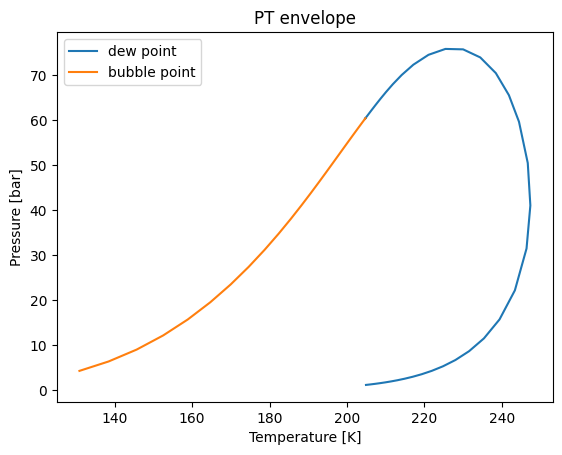

<java object 'neqsim.thermodynamicOperations.ThermodynamicOperations'>

In [ ]:
#Create the initial fluid composition in NeqSim

# Composition of loaded LNG
naturalgas = {'ComponentName':  ["nitrogen", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane"],
        'MolarComposition[-]':  [1.34, 95.4, 2.199, 1.06, 0.36, 0.55, 0.14, 0.097, 0.0014]
}

naturalgasdf = pd.DataFrame(naturalgas)
print("Initial LNG composition:\n")
print(naturalgasdf.head(30).to_string())
lngfluid = fluid_df(naturalgasdf)
print("\nPhase envelope of LNG\n")
phaseenvelope(lngfluid, True)

In [ ]:
#Input inital conditions

#eosmodel = "srk" #gerg-2008  pr-LK

pressure_transport = 1.01325 #pressure in bara
volume_initial = 125000 #initial LNG filling volume in m^3
time_transport = 48 # transport time in hours
BOR = 0.1 #boil off rate in unit % of initial LNG volume

#Set IOS6976 specifications
isoversion = "2016"
refvolT = 15.0 # reference temperature for calculation of standard density
refEnergyT = 15.0 # reference temperature for calculation of GCV/WI

In [ ]:
from neqsim import jNeqSim

#lngfluid.setModel(eosmodel)
lngfluid.setPressure(pressure_transport, 'bara')
lngfluid.setTemperature(-160.0, "C"); #setting a guessed initial temperature

ship = jNeqSim.fluidMechanics.flowSystem.twoPhaseFlowSystem.shipSystem.LNGship(lngfluid, volume_initial, BOR / 100.0)
ship.useStandardVersion("", "2016")
ship.getStandardISO6976().setEnergyRefT(refEnergyT)
ship.getStandardISO6976().setVolRefT(refvolT)
ship.setEndTime(time_transport)
ship.createSystem()
ship.solveSteadyState(0)
ship.solveTransient(0)
ageingresults = ship.getResults("temp")

In [ ]:
results = ageingresults[1:]
columns = ageingresults[0:1]
resultsDF = pd.DataFrame([[float(str(j).replace(',','')) for j in i] for i in results])
resultsDF.columns = ['time', 'temperature','GCV','WI','density','volume','C1','C2','C3','iC4','nC4','iC5','nC5','C6','N2','energy', 'GCV_mass', 'gC1','gC2','gC3','giC4','gnC4','giC5','gnC5','gC6','gN2']

resultsDF.to_excel('data.xlsx')
resultsDF

,time,temperature,GCV,WI,density,volume,C1,C2,C3,iC4,...,GCV_mass,gC1,gC2,gC3,giC4,gnC4,giC5,gnC5,gC6,gN2
0,0.00000,-163.72913,51.07479,39.52249,450.44678,125000.00000,0.94318,0.02174,0.01048,0.00356,...,53.85730,0.76280,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.23718
1,0.48485,-163.72792,51.07518,39.52275,450.44396,124997.48167,0.94318,0.02174,0.01048,0.00356,...,53.85777,0.76288,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.23709
2,0.96970,-163.72671,51.07557,39.52301,450.44115,124994.96325,0.94319,0.02174,0.01048,0.00356,...,53.85824,0.76297,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.23701
3,1.45455,-163.72551,51.07596,39.52327,450.43833,124992.44468,0.94319,0.02174,0.01048,0.00356,...,53.85872,0.76305,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.23693
4,1.93939,-163.72430,51.07635,39.52353,450.43552,124989.92597,0.94320,0.02174,0.01048,0.00356,...,53.85919,0.76313,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.23685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,46.06061,-163.61592,51.11144,39.54688,450.18379,124760.12823,0.94358,0.02179,0.01050,0.00357,...,53.90136,0.77055,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.22943
96,46.54545,-163.61475,51.11182,39.54713,450.18107,124757.59646,0.94359,0.02179,0.01050,0.00357,...,53.90182,0.77063,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.22935
97,47.03030,-163.61357,51.11220,39.54739,450.17835,124755.06455,0.94359,0.02179,0.01050,0.00357,...,53.90228,0.77071,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.22927
98,47.51515,-163.61240,51.11258,39.54764,450.17563,124752.53250,0.94360,0.02179,0.01050,0.00357,...,53.90273,0.77079,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.22918


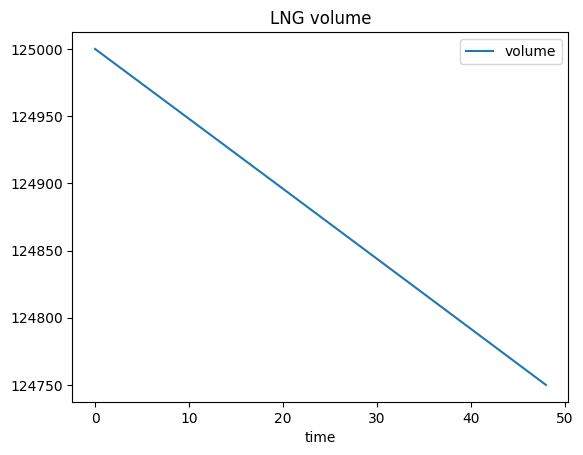

In [ ]:
resultsDF.plot(x='time', y=['volume'], kind='line', title='LNG volume')
plt.show()

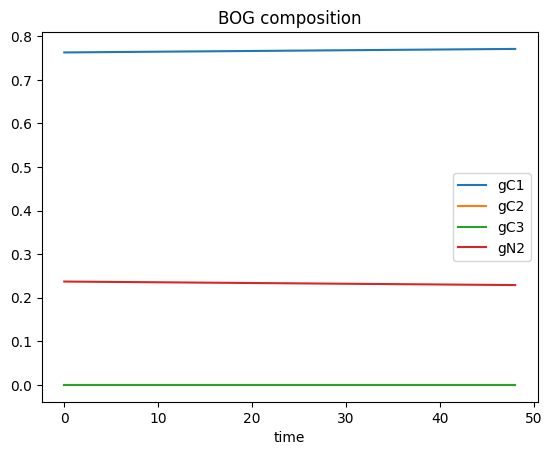

In [ ]:
resultsDF.plot(x='time', y=['gC1', 'gC2', 'gC3', 'gN2'], kind='line', title='BOG composition')
plt.show()

#Mathematics of LNG ageing calculations

See implementation:
https://github.com/equinor/neqsim/blob/717133f1a2134e47d7f31c43923e0b5b77fc6278/src/main/java/neqsim/fluidMechanics/flowSystem/twoPhaseFlowSystem/shipSystem/LNGship.java#L168



ship.createSystem()

    standardDensity = new Standard_ISO6578(getThermoSystem());
    timeStep = getEndTime() / (numberOffTimeSteps * 1.0 - 1.0);
    dailyBoilOffVolume = totalTankVolume * dailyBoilOffRatio;

ship.solveSteadyState(0)

    thermoOperations.bubblePointTemperatureFlash();


ship.solveTransient(0)

      endVolume = totalTankVolume - mulitplicator * dailyBoilOffVolume * getEndTime() / 24.0;
      molarBoilOffRate = dailyBoilOffVolume * liquidDensity
      / getThermoSystem().getPhase(1).getMolarMass() / 24.0 * timeStep;
      ....
      thermoOperations.bubblePointTemperatureFlash();
      ....
      for (int i = 0; i < getThermoSystem().getPhase(0).getNumberOfComponents(); i++) {
        getThermoSystem().addComponent(getThermoSystem().getPhase(0).getComponent(i).getName(),
            -xgas[i] * molarBoilOffRate);
      }
      ...



# How to implement more advanced methods

* Use of liquid lNG for propulsion
* Temperature and composition gradients
* Not constant pressure..



In [ ]:
#Input inital conditions

pressure_transport = [1.01325, 1.011325]  #pressure in bara
volume_initial = [125000, 124984] #initial LNG filling volume in m^3
time_transport = [0, 10.0] # transport time in hours
BOG_NATURAL = [0, 1000, 2000] # cummulaitve volume sent to engine Sm3^3 / 24 hr
BOG_FVAP = [0, 10.0, 10.0] # cummulaitve volume sent to engine Sm3^3 / 24 hr




BOR = 0.1 #boil off rate in unit % of initial LNG volume

#Set IOS6976 specifications
isoversion = "2016"
refvolT = 15.0 # reference temperature for calculation of standard density
refEnergyT = 15.0 # reference temperature for calculation of GCV/WI